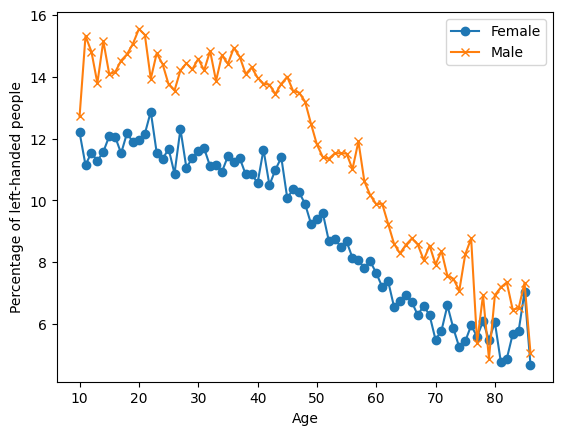

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data_url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
lefthanded_data = pd.read_csv(data_url_1)

fig, ax = plt.subplots()
ax.plot('Age', 'Female', data=lefthanded_data, marker='o')
ax.plot('Age', 'Male', data=lefthanded_data, marker='x')
ax.legend()
ax.set_xlabel("Age")
ax.set_ylabel("Percentage of left-handed people")
plt.show()

# left handedness vs age

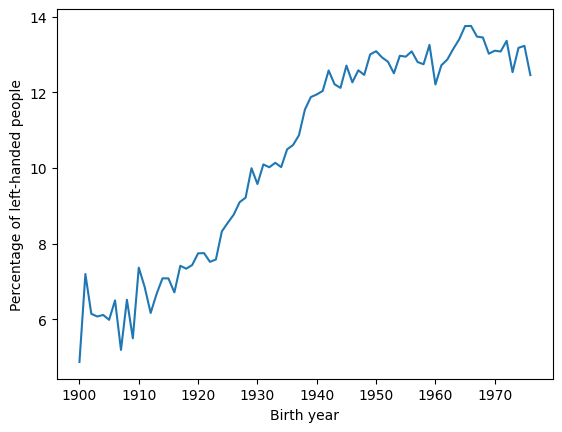

In [19]:
# new column for birth year of each age
lefthanded_data['Birth_year'] = 1986 - lefthanded_data['Age']

# new column for the average of male and female
lefthanded_data['Mean_lh'] = lefthanded_data[['Female', 'Male']].mean(axis=1)

# plot of the 'Mean_lh' column vs. 'Birth_year'
fig, ax = plt.subplots()
# plot 'Mean_lh' vs. 'Birth_year'
ax.plot('Birth_year', 'Mean_lh', data= lefthanded_data)

# set the x label for the plot
ax.set_xlabel('Birth year') 
# set the y label for the plot
ax.set_ylabel('Percentage of left-handed people');
plt.show()


In [20]:
# import library
import numpy as np

# function for P(LH | A)
def P_lh_given_A(ages_of_death, study_year = 1990):
    """ P(Left-handed | ages of death), calculated based on the reported rates of left-handedness.
    Inputs: numpy array of ages of death, study_year
    Returns: probability of left-handedness given that subjects died in `study_year` at ages `ages_of_death` """
    
    # Use the mean of the 10 last and 10 first points for left-handedness rates before and after the start 
    early_1900s_rate = lefthanded_data['Mean_lh'][-10:].mean()
    late_1900s_rate = lefthanded_data['Mean_lh'][:10].mean()
    middle_rates = lefthanded_data.loc[lefthanded_data['Birth_year'].isin(study_year - ages_of_death)]['Mean_lh']
    
    # the youngest age is 10
    youngest_age = study_year - 1986 + 10 
    # the oldest age is 86
    oldest_age = study_year - 1986 + 86 
    
    # create an empty array to store the results
    P_return = np.zeros(ages_of_death.shape)
    
    # extract rate of left-handedness for people of ages 'ages_of_death'
    P_return[ages_of_death > oldest_age] = early_1900s_rate / 100
    P_return[ages_of_death < youngest_age] = late_1900s_rate / 100
    P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates / 100
    
    return P_return

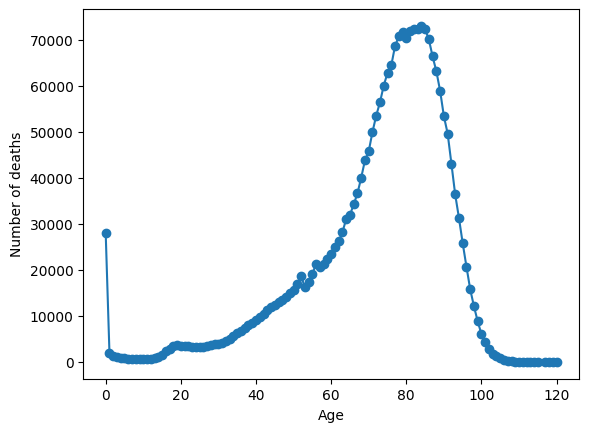

In [22]:
# Death distribution data for the United States in 1999
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"

# load death distribution data
death_distribution_data = pd.read_csv(data_url_2, sep='\t', skiprows=[1])

# drop NaN values from the `Both Sexes` column
death_distribution_data = death_distribution_data.dropna(subset = ['Both Sexes'])

# plot number of people who died as a function of age
fig, ax = plt.subplots()

# plot 'Both Sexes' vs. 'Age'
ax.plot('Age', 'Both Sexes', data = death_distribution_data, marker='o') 
ax.set_xlabel('Age') 
ax.set_ylabel('Number of deaths');

load in the death distribution data and plot it.

In [26]:
def P_lh(death_distribution_data, study_year = 1990): # sum over P_lh for each age group
    """ Overall probability of being left-handed if you died in the study year
        Input: dataframe of death distribution data, study year
        Output: P(LH), a single floating point number """
    
    # multiply number of deaths by P_lh_given_A
    p_list = death_distribution_data['Both Sexes'] * P_lh_given_A(death_distribution_data['Age'], study_year)
    
    # sum of p_list
    p = sum(p_list)
    
    # normalize to total number of people (sum of death_distribution_data['Both Sexes'])
    return p / np.sum(death_distribution_data['Both Sexes']) 

print(P_lh(death_distribution_data))


0.07766387615350637


In [25]:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / np.sum(death_distribution_data['Both Sexes'])
    
     # use the P_lh function to get probability of left-handedness overall
    P_left = P_lh(death_distribution_data, study_year)
    
    # use the P_lh_given_A to get probability of left-handedness for a certain age
    P_lh_A = P_lh_given_A(ages_of_death, study_year) 
    
    return P_lh_A * P_A / P_left

In [28]:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / np.sum(death_distribution_data['Both Sexes'])
    
    # either you're left-handed or right-handed
    P_right = 1 - P_lh(death_distribution_data, study_year)
    
    # P_rh_A = 1 - P_lh_A
    P_rh_A = 1 - P_lh_given_A(ages_of_death, study_year)
    
    return P_rh_A * P_A / P_right

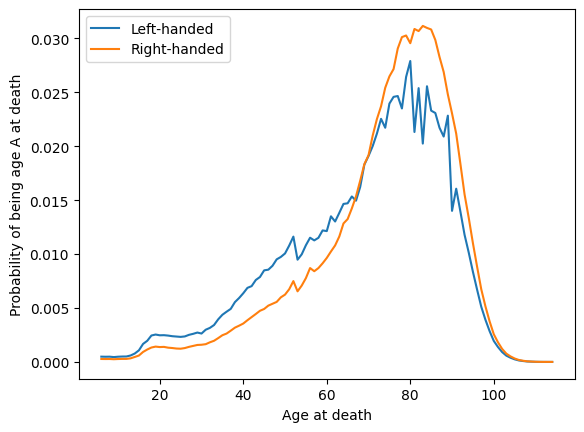

In [29]:
# make a list of ages of death to plot
ages = np.arange(6, 115, 1) 
# calculate the probability of being left- or right-handed for each 
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)
# create figure and axis objects
fig, ax = plt.subplots() 
# create a plot of the two probabilities vs. age
ax.plot(ages, left_handed_probability, label = "Left-handed")
ax.plot(ages, right_handed_probability, label = "Right-handed")
ax.legend()
ax.set_xlabel("Age at death")
ax.set_ylabel(r"Probability of being age A at death");

In [31]:
# calculate average ages for left-handed and right-handed groups
# use np.array so that two arrays can be multiplied
average_lh_age =  np.nansum(ages*np.array(left_handed_probability))
average_rh_age =  np.nansum(ages*np.array(right_handed_probability))

# print the average ages for each group
print(round(average_lh_age, 1))
print(round(average_rh_age, 1))

# print the difference between the average ages
print("The difference in average ages is " + str(round(average_rh_age - average_lh_age, 1)) + " years.")

67.2
72.8
The difference in average ages is 5.5 years.


In [33]:
# Calculate the probability of being left- or right-handed for all ages
left_handed_probability_2018 = P_A_given_lh(ages, death_distribution_data, study_year= 2018)
right_handed_probability_2018 = P_A_given_rh(ages, death_distribution_data, study_year= 2018)

# calculate average ages for left-handed and right-handed groups
average_lh_age_2018 = np.nansum(ages*np.array(left_handed_probability_2018))
average_rh_age_2018 = np.nansum(ages*np.array(right_handed_probability_2018))

print("The difference in average ages is " + 
      str(round(average_rh_age_2018 - average_lh_age_2018, 1)) + " years.")

The difference in average ages is 2.3 years.
